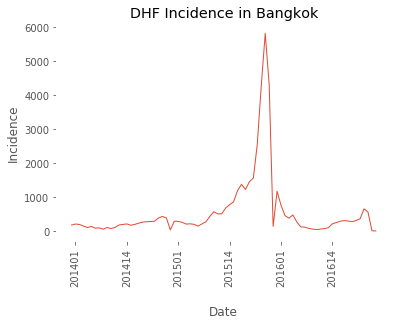

In [1]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1
plt.rcParams['axes.facecolor']='w'

n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "10":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
np.set_printoptions(suppress=True)    #np.set_printoptions(threshold=np.nan)

def sim_data(x,y,z):
    return reporting_matrix[:y]



pos=[]
biweek_x_label = []
for year in ["2014","2015","2016"]:
    for j in np.arange(1,27,13):
        if j <= 9:
               biweek_x_label.append(year + "0"+ str(j))

        else:
               biweek_x_label.append(year +  str(j))
        if year == "2014":
               pos.append(j)
        elif year == "2015":
               pos.append(j+26)
        elif year == "2016":
               pos.append(j+26*2)


plt.plot(reporting_matrix.sum(axis=1))
plt.xticks(pos, biweek_x_label, rotation='vertical')
plt.xlabel("\nDate")
plt.title("DHF Incidence in Bangkok")
plt.ylabel("Incidence")
plt.show()


In [58]:
def bayes_estimate_prob(po_data,m2,alphas,LO,N_SIM):
    ret_arr = []
    phat = alphas/sum(alphas)
    for s_ in range(N_SIM):
        count = LO
        for row in np.arange(LO,0,-1):
                tmp_n_t_inf = np.max((m2[s_][(D-row)],po_data[D-row]))
                sigma_2_0 = 10
                sigma_2 =   tmp_n_t_inf*sum(phat[:row])*(1-sum(phat[:row]))
                post_mean = (1.*sigma_2_0/(sigma_2_0+sigma_2))*po_data[D-row] \
                          +(1.*sigma_2/(sigma_2_0+sigma_2))*tmp_n_t_inf
                post_var = 1./(1./sigma_2_0 + 1./sigma_2) + .000001
                
                

                ret_arr.append(np.random.normal(post_mean, 25*np.sqrt(post_var),size=100))
                count -=1
    
    return ret_arr

In [59]:
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

import os
D=26
rmse_vec_cv = []
#with suppress_stdout():
rmse_vec = []
sim_data_var = []
N_SIM = 1000
sim_results_pi = []
sim_results_mse = []
for sim_num in np.arange(30,60):
            sim_n_t_d = sim_data(D,sim_num,False)
            train = sim_n_t_d
            


            train = np.array(train)
            train_n_t_d = train.reshape((-1,D))
            ts = train_n_t_d.sum(axis=1)
            data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]




            delayed_data = []
            count = D
            for i in range(len(data_to_be_scaled_down)):
                tmp = data_to_be_scaled_down[i][:count].tolist()
                while len(tmp) <D:
                    tmp.append(0)
                delayed_data.append(tmp)
                count -=1 


            training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

            k = np.array(train_n_t_d).shape[1 ]
            alphas = np.ones(k)

            for i in range(len(ts)-D):
                alphas += train_n_t_d[i]

            
           
            #######
            # MODEL 1: Delay
            ########
            delay_model_samples = []
            for s_ in range(N_SIM):
                model_1_delay = []
                count = D
                p_vec_noise = np.random.dirichlet(alphas)
                for i in range(len(delayed_data)):
                    delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                    model_1_delay.append(np.round(delay_forecast,2))
                    count -= 1
                delay_model_samples.append(model_1_delay)
            
            delay_model_samples = np.array(delay_model_samples)
            

            #######
            # MODEL 2 : Forecast
            ########
            
            LO=5
            process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
            from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
            myDLM = dlm(process_training_data)
           # myDLM = myDLM + seasonality(26, name='7day', w=1.0)
            myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
            myDLM.fit()
            (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)
            
            #######
            # MODEL 2
            ########
            forecast_model_samples = []
            for s_ in range(N_SIM):
                model_2_delay = []
                count = D
                for i in np.arange(LO,0,-1):
                    tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                    model_2_delay.append(np.round(tmp,2))
                    count -= 1

                forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))
            
            forecast_model_samples = np.array(forecast_model_samples)
            
                
            model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)
            
            model_average = np.transpose(np.array(model_average).reshape((-1,LO)))
            delay_model_samples = np.transpose(np.array(delay_model_samples))
            forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
            delay_sim_res = delay_model_samples
            fcast_sim_res = forecast_model_samples
            avg_sim_res = model_average
            LO_av = avg_sim_res
            LO_delay = delay_sim_res[D-LO:]
            LO_fcast = fcast_sim_res[D-LO:]
            LO_truth = ts[len(ts)-LO:]
            
            sim_results_mse.append([mean_squared_error(np.mean(LO_delay,axis=1),LO_truth),\
                                   mean_squared_error(np.mean(LO_fcast,axis=1),LO_truth),\
                                   mean_squared_error(np.mean(LO_av,axis=1),LO_truth)])
            print (sim_results_mse[-1])
            av_cp = 0
            fcast_cp = 0
            delay_cp = 0
            for i in range(LO):
                LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
                LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
                LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
                print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
                if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                    av_cp +=1

                if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                    fcast_cp +=1

                if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                    delay_cp +=1


            av_cp = 1.*av_cp/LO
            fcast_cp = 1.*fcast_cp/LO
            delay_cp = 1.*delay_cp/LO

            print (delay_cp,fcast_cp,av_cp)
            sim_results_pi.append([delay_cp,fcast_cp,av_cp])
    


        

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.2, 0.18504349345999999, 0.18018414284114675]
(array([0., 0.]), array([-12.,  12.]), array([-12.,  13.]), 0.0)
(array([0., 0.]), array([-12.,  11.]), array([-12.,  13.]), 0.0)
(array([0., 0.]), array([-11.,  12.]), array([-12.,  12.]), 0.0)
(array([0., 0.]), array([-12.,  12.]), array([-12.,  13.]), 1.0)
(array([0., 0.]), array([-12.,  12.]), array([-12.,  13.]), 0.0)
(0.8, 1.0, 1.0)
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
[265.4121929228799, 0.4682130161200003, 0.2758960514182528]
(array([17., 84.]), array([-11.,  11.]), array([-12.,  12.]), 1.0)
(array([0., 0.]), array([-11.,  11.]), array([-11.,  12.]), 0.0)
(array([0., 0.]), array([-11.,  11.]), array([-12.,  13.]), 0.0)
(array([0., 0.]), 

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
[14506.148338719326, 924.5226677292201, 957.2537333348926]
(array([0., 0.]), array([-29.,  34.]), array([-22.,  25.]), 53.0)
(array([17., 61.]), array([-28.,  30.]), array([-22.,  25.]), 8.0)
(array([0., 0.]), array([-30.,  31.]), array([-22.,  25.]), 0.0)
(array([0., 0.]), array([-33.,  32.]), array([-22.,  26.]), 45.0)
(array([ 75., 854.]), array([-30.,  29.]), array([-22.,  25.]), 10.0)
(0.2, 0.6, 0.6)
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
[10604.59682581785, 518.3706042780399, 496.53361222623755]
(array([0., 0.]), array([-29.,  30.]), array([-22.,  25.]), 45.0)
(array([ 33., 105.]), array([-28.,  28.]), array([-22.,  25.]), 10.0)
(array([0., 0.]), array([-28.,  27.]), array([-22.,  25.]), 

[10.0, 10.919894991960003, 8.018557693094447]
(array([0., 0.]), array([-28.,  34.]), array([-34.,  39.]), 0.0)
(array([0., 0.]), array([-31.,  31.]), array([-34.,  40.]), 7.0)
(array([0., 0.]), array([-30.,  32.]), array([-34.,  39.]), 0.0)
(array([0., 0.]), array([-31.,  30.]), array([-34.,  39.]), 0.0)
(array([0., 0.]), array([-29.,  32.]), array([-34.,  39.]), 1.0)
(0.6, 1.0, 1.0)


In [63]:
#### sim_results_pi = np.array(sim_results_pi)
print np.mean(sim_results_pi,axis=0)

sim_results_mse = np.array(sim_results_mse)
print np.round(np.mean(sim_results_mse,axis=0)/10)


[0.36666667 0.84666667 0.85333333]
[3132.   54.   51.]


In [64]:
from scipy.special import expit
import matplotlib.pyplot as pltq

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

cv_mse = []
season_data = []
sim_results_mse = []
sim_results_pi = []
for i in range(3):
    season_data.append(reporting_matrix[i:(i+26)])
    
season_data = np.array(season_data).reshape((3,-1,26))

print (season_data.shape)

for season_for_leave_out in np.arange(3):
        sim_n_t_d = season_data#[:cutoff]

        train = [sim_n_t_d[x] for x in range(3) if x not in [season_for_leave_out]]
        test = sim_n_t_d[season_for_leave_out]
        
        train = np.array(train)
        train_n_t_d = train.reshape((-1,D))
        ts = train_n_t_d.sum(axis=1)

        data_to_be_scaled_down  = test[len(test)-D:]
       
        delayed_data = []
        count = D
        for i in range(len(data_to_be_scaled_down)):
            tmp = data_to_be_scaled_down[i][:count].tolist()
            while len(tmp) <D:
                tmp.append(0)
            delayed_data.append(tmp)
            count -=1 


        training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

        k = np.array(train_n_t_d).shape[1 ]
        alphas = np.ones(k)

        for i in range(len(ts)-D):
            alphas += train_n_t_d[i]



        #######
        # MODEL 1: Delay
        ########
        delay_model_samples = []
        for s_ in range(N_SIM):
            model_1_delay = []
            count = D
            p_vec_noise = np.random.dirichlet(alphas)
            for i in range(len(delayed_data)):
                delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                model_1_delay.append(np.round(delay_forecast,2))
                count -= 1
            delay_model_samples.append(model_1_delay)

        delay_model_samples = np.array(delay_model_samples)


        #######
        # MODEL 2 : Forecast
        ########

        LO=5
        process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(process_training_data)
       # myDLM = myDLM + seasonality(26, name='7day', w=1.0)
        myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
        myDLM.fit()
        (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)

        #######
        # MODEL 2
        ########
        forecast_model_samples = []
        for s_ in range(N_SIM):
            model_2_delay = []
            count = D
            for i in np.arange(LO,0,-1):
                tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                model_2_delay.append(np.round(tmp,2))
                count -= 1

            forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))

        forecast_model_samples = np.array(forecast_model_samples)


        model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)

        model_average = np.transpose(np.array(model_average).reshape((-1,LO)))
        delay_model_samples = np.transpose(np.array(delay_model_samples))
        forecast_model_samples = np.transpose(np.array(forecast_model_samples))

        delay_sim_res = delay_model_samples
        fcast_sim_res = forecast_model_samples
        avg_sim_res = model_average
        LO_av = avg_sim_res
        LO_delay = delay_sim_res[D-LO:]
        LO_fcast = fcast_sim_res[D-LO:]
        LO_truth = ts[len(ts)-LO:]

        sim_results_mse.append([mean_squared_error(np.mean(LO_delay,axis=1),LO_truth),\
                               mean_squared_error(np.mean(LO_fcast,axis=1),LO_truth),\
                               mean_squared_error(np.mean(LO_av,axis=1),LO_truth)])
        print (sim_results_mse[-1])
        av_cp = 0
        fcast_cp = 0
        delay_cp = 0
        for i in range(LO):
            LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
            LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
            LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
            print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
            if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                av_cp +=1

            if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                fcast_cp +=1

            if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                delay_cp +=1


        av_cp = 1.*av_cp/LO
        fcast_cp = 1.*fcast_cp/LO
        delay_cp = 1.*delay_cp/LO

        print (delay_cp,fcast_cp,av_cp)
        sim_results_pi.append([delay_cp,fcast_cp,av_cp])



    

(3, 78, 26)
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
[1455.3619463585806, 2.64838392456, 1.9742103361758208]
(array([ 45., 173.]), array([-11.,  12.]), array([-11.,  12.]), 3.0)
(array([0., 0.]), array([-12.,  10.]), array([-11.,  13.]), 0.0)
(array([0., 0.]), array([-11.,  11.]), array([-11.,  13.]), 0.0)
(array([0., 0.]), array([-11.,  12.]), array([-11.,  12.]), 2.0)
(array([0., 0.]), array([-12.,  11.]), array([-11.,  13.]), 0.0)
(0.6, 1.0, 1.0)
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.6, 2.7906447344599994, 2.5472584789144217]
(array([0., 0.]), array([-12.,  12.]), array([-11.,  11.]), 3.0)
(array([0., 0.]), array([-12.,  12.]), array([-11.,  11.]), 0.0)
(array([0., 0.]), array([-11.,  12.]), array([-11.,  11.]), 0.0)
(array([0.

In [67]:
#### sim_results_pi = np.array(sim_results_pi)
print np.mean(sim_results_pi,axis=0)

sim_results_mse = np.array(sim_results_mse)
print np.round(np.mean(sim_results_mse,axis=0)/1)


[0.6 1.  1. ]
[1129.    2.    2.]
